Import des librairies

In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind
import statsmodels.api as sm
import glob
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages

Definitions des chemins

In [2]:
STUDY_DIR=os.path.join("/NAS","coolio","protocoles","Track_PD_DTA")
DERIVATIVE_DIR_DIR=os.path.join(STUDY_DIR,"bids_data","derivatives_wCorrectedFS")

In [3]:
# Obtenir la date actuelle
date_actuelle = datetime.now()
# Formater la date
date_formattee = date_actuelle.strftime("%Y_%m_%d_%H%M%S")
#pdf=PdfPages(os.path.join(STUDY_DIR,"results","Analyse_GC_"+date_formattee+".pdf"))

# Population study (only clinical and demographic data ), no images here ;-) 

In [4]:
#RES_FILE=os.path.join("/NAS","coolio","protocoles","Track_PD_DTA","bids_data","participants.tsv")
RES_FILE=os.path.join("/NAS","coolio","protocoles","Track_PD_DTA","participants-GC_RV.csv")
val = pd.read_csv(RES_FILE,index_col=0)
val

GROUP_NUM GROUP_NAME  Sex   Age  BDI_tot  PAS_tot
participant_id                                                   
sub-TRACK-P001          3         HC    1  60.0      2.0      5.0
sub-TRACK-P002          3         HC    1  45.0      0.0      1.0
sub-TRACK-P003          2    NoAnxPD    1  74.0     10.0      6.0
sub-TRACK-P004          3         HC    0  45.0      1.0      4.0
sub-TRACK-P005          3         HC    1  65.0      2.0      8.0
...                   ...        ...  ...   ...      ...      ...
sub-TRACK-P147          3         HC    1  58.0     10.0      7.0
sub-TRACK-P148          3         HC    1  55.0      1.0      3.0
sub-TRACK-P149          3         HC    1  73.0      2.0      5.0
sub-TRACK-P150          3         HC    1  60.0      7.0      5.0
sub-TRACK-P151          3         HC    1  73.0     10.0     11.0

[148 rows x 6 columns]

PAS_tot and BDI_tot by groups 

<Axes: xlabel='GROUP_NAME', ylabel='PAS_tot'>

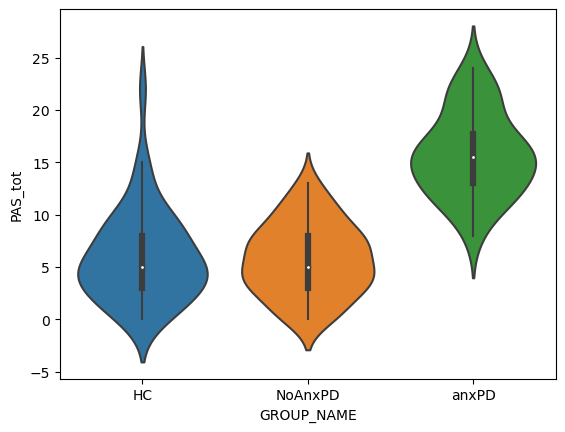

In [5]:
sns.violinplot(val,y="PAS_tot",x="GROUP_NAME",split=True)
#pdf.savefig()

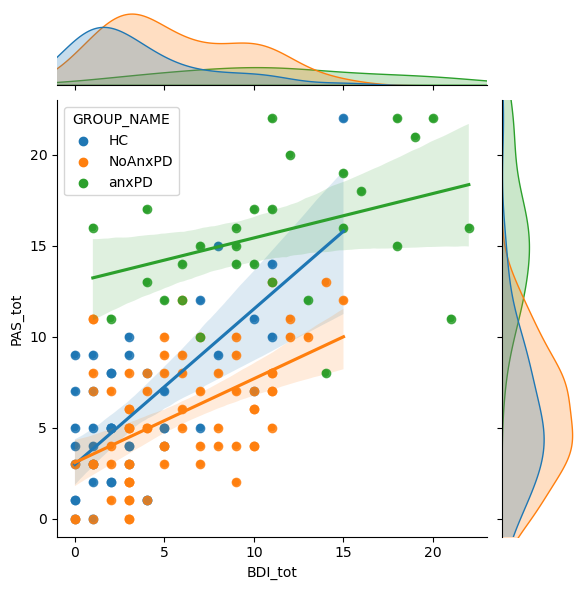

In [23]:
sns.jointplot(val,y="PAS_tot",x="BDI_tot",hue="GROUP_NAME")
plt.gca().set_xlim([-1, 23])
plt.gca().set_ylim([-1, 23])
# Ajouter une droite de régression à chaque hue
for diag in val["GROUP_NAME"].unique():
    sns.regplot(x="BDI_tot", y="PAS_tot", data=val[val["GROUP_NAME"] == diag])
#pdf.savefig()

In [24]:
###########
#Chargement des surfaces
###########
lh_surface_file=os.path.join(DERIVATIVE_DIR_DIR,"freesurfer","fsLR-32k","surf","fsLR-32k.L.inflated.surf.gii")
lh_surface_data = read_surface(lh_surface_file, itype='gii')

rh_surface_file=os.path.join(DERIVATIVE_DIR_DIR,"freesurfer","fsLR-32k","surf","fsLR-32k.R.inflated.surf.gii")
rh_surface_data = read_surface(rh_surface_file, itype='gii')

FWHM=8
###########
#Chargement de l'épaisseur corticale moyenne pour le groupe G1 PD_Anx
###########
lh_file= os.path.join(STUDY_DIR,"results","Palm_CT_"+str(FWHM)+"_GROUP_FScorr","mean_G1_CT.L_sm"+str(FWHM)+".func.gii")
lh_volume = [x.data for x in nib.load(lh_file).darrays] 

rh_file= os.path.join(STUDY_DIR,"results","Palm_CT_"+str(FWHM)+"_GROUP_FScorr","mean_G1_CT.R_sm"+str(FWHM)+".func.gii")
rh_volume = [x.data for x in nib.load(rh_file).darrays]

volumeG1 = np.concatenate([lh_volume[0],rh_volume[0]], axis=0)

###########
#Chargement de l'épaisseur corticale moyenne pour le groupe G2 PD_NonAnx
###########
lh_file= os.path.join(STUDY_DIR,"results","Palm_CT_"+str(FWHM)+"_GROUP_FScorr","mean_G2_CT.L_sm"+str(FWHM)+".func.gii")
lh_volume = [x.data for x in nib.load(lh_file).darrays] 

rh_file= os.path.join(STUDY_DIR,"results","Palm_CT_"+str(FWHM)+"_GROUP_FScorr","mean_G2_CT.R_sm"+str(FWHM)+".func.gii")
rh_volume = [x.data for x in nib.load(rh_file).darrays]

volumeG2 = np.concatenate([lh_volume[0],rh_volume[0]], axis=0)

###########
#Chargement de l'épaisseur corticale moyenne pour le groupe G3 HC
###########
lh_file= os.path.join(STUDY_DIR,"results","Palm_CT_"+str(FWHM)+"_GROUP_FScorr","mean_G3_CT.L_sm"+str(FWHM)+".func.gii")
lh_volume = [x.data for x in nib.load(lh_file).darrays] 

rh_file= os.path.join(STUDY_DIR,"results","Palm_CT_"+str(FWHM)+"_GROUP_FScorr","mean_G3_CT.R_sm"+str(FWHM)+".func.gii")
rh_volume = [x.data for x in nib.load(rh_file).darrays]

volumeG3 = np.concatenate([lh_volume[0],rh_volume[0]], axis=0)

tmp=nib.load(os.path.join(STUDY_DIR,"results","Palm_CT_"+str(FWHM)+"_GROUP_FScorr","CT.L_sm"+str(FWHM)+"_G1.func.gii")) 
n_G1=len(tmp.darrays)

tmp=nib.load(os.path.join(STUDY_DIR,"results","Palm_CT_"+str(FWHM)+"_GROUP_FScorr","CT.L_sm"+str(FWHM)+"_G2.func.gii"))
n_G2=len(tmp.darrays)

tmp=nib.load(os.path.join(STUDY_DIR,"results","Palm_CT_"+str(FWHM)+"_GROUP_FScorr","CT.L_sm"+str(FWHM)+"_G3.func.gii")) 
n_G3=len(tmp.darrays)

labels = ['PD_Anx n='+str(n_G1),'PD_NonAnx n='+str(n_G2),'HC n='+str(n_G3)]

# ROI analysis using FreeSurfer extraction

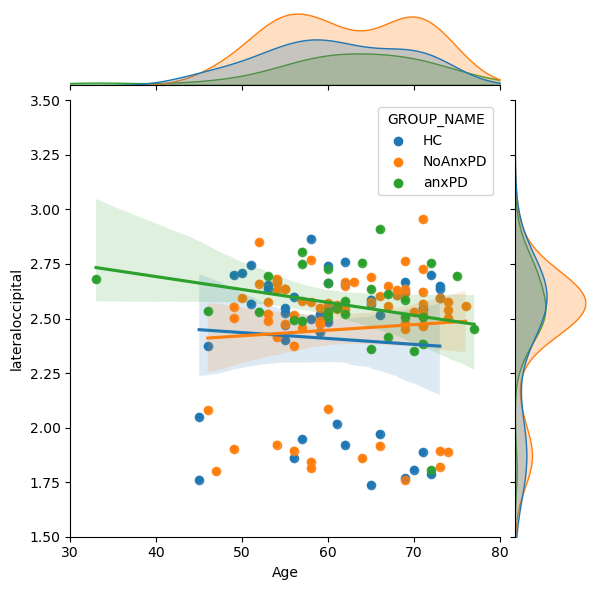

In [25]:
CT_FS_FILE=os.path.join("/NAS","coolio","protocoles","Track_PD_DTA","ThicknessPerPts_rh.csv")
ct_fs_df = pd.read_csv(CT_FS_FILE,index_col=0)
ct_fs_df.index = ct_fs_df.index.str.replace("_FS", "")
ct_fs_df.index = ct_fs_df.index.str.replace("TRACK", "sub-TRACK")

DATA_FILE=os.path.join("/NAS","coolio","protocoles","Track_PD_DTA","participants-GC_RV.csv")
DATA_FILE = pd.read_csv(DATA_FILE,index_col=0)

df = pd.concat([DATA_FILE, ct_fs_df], axis=1, join="inner")

sns.jointplot(df,y="lateraloccipital",x="Age",hue="GROUP_NAME")
plt.gca().set_xlim([30, 80])
plt.gca().set_ylim([1.5,3.5])
for diag in df["GROUP_NAME"].unique():
    sns.regplot(x="Age", y="lateraloccipital", data=df[df["GROUP_NAME"] == diag])

# Cortical thickness map per group

Text(0.5, 1.0, 'Mean cortical map of each group')

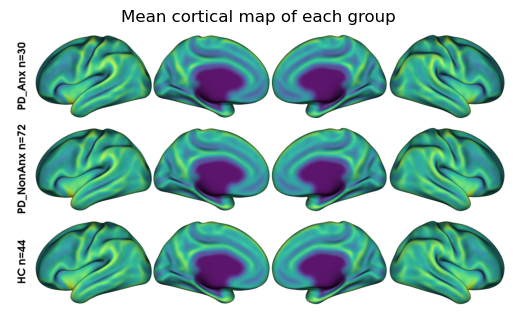

In [29]:
figure_title=os.path.join(STUDY_DIR,"results","groupes_C1_C2.png")

plot_hemispheres(lh_surface_data, rh_surface_data, array_name=[volumeG1,volumeG2,volumeG3],size=(1200,675),label_text=labels,zoom=1.6,embed_nb=True,interactive=True,nan_color=(0, 0, 0, 1),transparent_bg=False,screenshot=True, offscreen=True,filename=figure_title)
#plot_hemispheres(lh_surface_data, rh_surface_data, array_name=[volumeG1,volumeG2,volumeG3],size=(1200,675),label_text=labels,zoom=1.6,interactive=True,nan_color=(0, 0, 0, 1),transparent_bg=False)
image = plt.imread(figure_title)
#fig=plt.figure(figsize=figsize)
fig=plt.imshow(image)
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.title('Mean cortical map of each group')
#pdf.savefig()

# Comparison between groups

In [8]:
resV=[]
resF=[]
files = glob.glob(os.path.join(STUDY_DIR,"results","Palm_4_GC_F_CT_*_Anxiety","results_CT_*_tfce_fstat_*.gii"))
for file in files:
    lh_volume = [x.data for x in nib.load(file).darrays] 
    resF.append(file.split('/')[6:8])
    resV.append(round(np.max(lh_volume[0]),2))
    #print(file.split('/')[6:8],round(np.max(lh_volume[0]),2))
    
print("Maximum value of ftest (-log(p)) , smoothing X mm ex: Palm_4_GC_F_CT_X_Anxiety, side (R/L) with or without covariables (wCov/woCov), with or without correction (fwep/uncp)")  
val_sorted=sorted(zip(resV,resF),reverse=True)
val_sorted

Maximum value of ftest (-log(p)) , smoothing X mm ex: Palm_4_GC_F_CT_X_Anxiety, side (R/L) with or without covariables (wCov/woCov), with or without correction (fwep/uncp)


[(2.27, ['Palm_4_GC_F_CT_4_Anxiety', 'results_CT_R_wCov_tfce_fstat_uncp.gii']),
 (2.25,
  ['Palm_4_GC_F_CT_4_Anxiety', 'results_CT_R_woCov_tfce_fstat_uncp.gii']),
 (2.21,
  ['Palm_4_GC_F_CT_4_Anxiety', 'results_CT_L_woCov_tfce_fstat_uncp.gii']),
 (2.12, ['Palm_4_GC_F_CT_4_Anxiety', 'results_CT_L_wCov_tfce_fstat_uncp.gii']),
 (2.05,
  ['Palm_4_GC_F_CT_8_Anxiety', 'results_CT_R_woCov_tfce_fstat_uncp.gii']),
 (1.89, ['Palm_4_GC_F_CT_8_Anxiety', 'results_CT_R_wCov_tfce_fstat_uncp.gii']),
 (1.88,
  ['Palm_4_GC_F_CT_8_Anxiety', 'results_CT_L_woCov_tfce_fstat_uncp.gii']),
 (1.81,
  ['Palm_4_GC_F_CT_12_Anxiety', 'results_CT_R_woCov_tfce_fstat_uncp.gii']),
 (1.8, ['Palm_4_GC_F_CT_8_Anxiety', 'results_CT_L_wCov_tfce_fstat_uncp.gii']),
 (1.78,
  ['Palm_4_GC_F_CT_12_Anxiety', 'results_CT_L_woCov_tfce_fstat_uncp.gii']),
 (1.61,
  ['Palm_4_GC_F_CT_16_Anxiety', 'results_CT_R_wCov_tfce_fstat_uncp.gii']),
 (1.59,
  ['Palm_4_GC_F_CT_16_Anxiety', 'results_CT_L_wCov_tfce_fstat_uncp.gii']),
 (1.59,
  ['Pal

## Statistical map of groups cortical thickness difference (uncorrected, significant threshold = 0.05 )

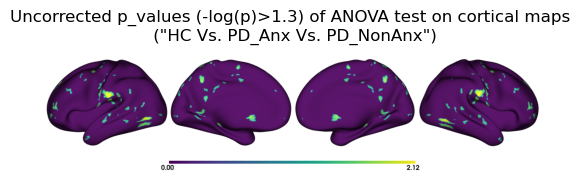

In [44]:
lh_file= os.path.join(STUDY_DIR,"results","Palm_4_GC_F_CT_4_Anxiety","results_CT_L_wCov_tfce_fstat_uncp.gii")
lh_volume = [x.data for x in nib.load(lh_file).darrays] 

rh_file= os.path.join(STUDY_DIR,"results","Palm_4_GC_F_CT_4_Anxiety","results_CT_L_wCov_tfce_fstat_uncp.gii")
rh_volume = [x.data for x in nib.load(rh_file).darrays]

volume_c1 = np.concatenate([lh_volume[0],rh_volume[0]], axis=0)
volume_c1[volume_c1<1.3]=0

#labels = ['Aggrav. > Stable \n C1>C2']

figure_title=os.path.join(STUDY_DIR,"results","Anova.png")
plot_hemispheres(lh_surface_data, rh_surface_data, array_name=[volume_c1],size=(1200, 300),zoom=1.4,color_bar='bottom',share='both',embed_nb=True,interactive=True,nan_color=(0, 0, 0, 1),transparent_bg=False,screenshot=True, offscreen=True,filename=figure_title)
image = plt.imread(figure_title)
fig=plt.imshow(image)
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.title('Uncorrected p_values (-log(p)>1.3) of ANOVA test on cortical maps \n ("HC Vs. PD_Anx Vs. PD_NonAnx")')
#pdf.savefig()
ind=np.where(volume_c1>1.3)

In [95]:
resV=[]
resF=[]
#files = glob.glob(os.path.join(STUDY_DIR,"results","Palm_Anx_Vs_NonANx_CT_*","results_CT*wCov_surf1_dpv_tstat_uncp*.gii"))
#test de pearson
files = glob.glob(os.path.join(STUDY_DIR,"results","Palm_REG_4_GC_CT_4*","results_CT_*_regpearson_dpv_rstat.gii"))
#files = glob.glob(os.path.join(STUDY_DIR,"results","Palm_REG_4_GC_CT_*","results_CT_*_dpv_tstat_uncp.gii"))
for file in files:
    lh_volume = [x.data for x in nib.load(file).darrays] 
    resF.append(file.split('/')[6:8])
    resV.append(round(np.min(lh_volume[0]),2))
    #print(file.split('/')[6:8],round(np.max(lh_volume[0]),2))
    
print("Maximum value of ftest (-log(p)) , smoothing X mm ex: Palm_4_GC_F_CT_X_Anxiety, side (R/L) with or without covariables (wCov/woCov), with or without correction (fwep/uncp)")  
val_sorted=sorted(zip(resV,resF),reverse=True)
val_sorted

Maximum value of ftest (-log(p)) , smoothing X mm ex: Palm_4_GC_F_CT_X_Anxiety, side (R/L) with or without covariables (wCov/woCov), with or without correction (fwep/uncp)


[(-0.33,
  ['Palm_REG_4_GC_CT_4_Anxiety_ALL', 'results_CT_R_regpearson_dpv_rstat.gii']),
 (-0.33,
  ['Palm_REG_4_GC_CT_4_Anxiety_ALL', 'results_CT_L_regpearson_dpv_rstat.gii']),
 (-0.4, ['Palm_REG_4_GC_CT_4_PD', 'results_CT_R_regpearson_dpv_rstat.gii']),
 (-0.4, ['Palm_REG_4_GC_CT_4_PD', 'results_CT_L_regpearson_dpv_rstat.gii']),
 (-0.46,
  ['Palm_REG_4_GC_CT_4_NoAnxPD', 'results_CT_R_regpearson_dpv_rstat.gii']),
 (-0.46,
  ['Palm_REG_4_GC_CT_4_NoAnxPD', 'results_CT_L_regpearson_dpv_rstat.gii']),
 (-0.55,
  ['Palm_REG_4_GC_CT_4_Anxiety_HC', 'results_CT_R_regpearson_dpv_rstat.gii']),
 (-0.55,
  ['Palm_REG_4_GC_CT_4_Anxiety_HC', 'results_CT_L_regpearson_dpv_rstat.gii']),
 (-0.69,
  ['Palm_REG_4_GC_CT_4_anxPD', 'results_CT_R_regpearson_dpv_rstat.gii']),
 (-0.69,
  ['Palm_REG_4_GC_CT_4_anxPD', 'results_CT_L_regpearson_dpv_rstat.gii'])]

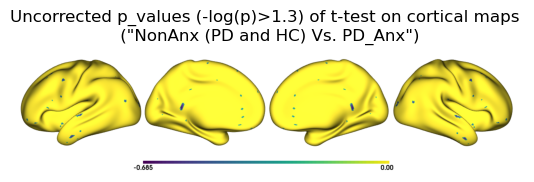

In [97]:
lh_file= os.path.join(STUDY_DIR,"results","Palm_Anx_Vs_NonANx_CT_12","results_CTL_wCov_surf1_dpv_tstat_uncp_c2.gii")
lh_file= os.path.join(STUDY_DIR,"results","Palm_REG_4_GC_CT_4_anxPD","results_CT_L_regpearson_dpv_rstat.gii")
lh_volume = [x.data for x in nib.load(lh_file).darrays] 

rh_file= os.path.join(STUDY_DIR,"results","Palm_Anx_Vs_NonANx_CT_12","results_CTR_wCov_surf1_dpv_tstat_uncp_c2.gii")
rh_file= os.path.join(STUDY_DIR,"results","Palm_REG_4_GC_CT_4_anxPD","results_CT_R_regpearson_dpv_rstat.gii")

rh_volume = [x.data for x in nib.load(rh_file).darrays]

volume_c1 = np.concatenate([lh_volume[0],rh_volume[0]], axis=0)
#volume_c1[volume_c1<3]=0
volume_c1[volume_c1>-0.5]=0

#labels = ['Aggrav. > Stable \n C1>C2']

figure_title=os.path.join(STUDY_DIR,"results","Anova.png")
plot_hemispheres(lh_surface_data, rh_surface_data, array_name=[volume_c1],size=(1200, 300),zoom=1.4,color_bar='bottom',share='both',embed_nb=True,interactive=True,nan_color=(0, 0, 0, 1),transparent_bg=False,screenshot=True, offscreen=True,filename=figure_title)
image = plt.imread(figure_title)
fig=plt.imshow(image)
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.title('Uncorrected p_values (-log(p)>1.3) of t-test on cortical maps \n ("NonAnx (PD and HC) Vs. PD_Anx")')
#pdf.savefig()
ind=np.where(volume_c1>1.3)

# Show the mean cortical thickness in the cluster where (p<0.05 eq. -log(p) > 1.3) against the PAS-Tot

Nb pts > mediane + 3 IQR :  0
Nb pts < mediane + 3 IQR :  0


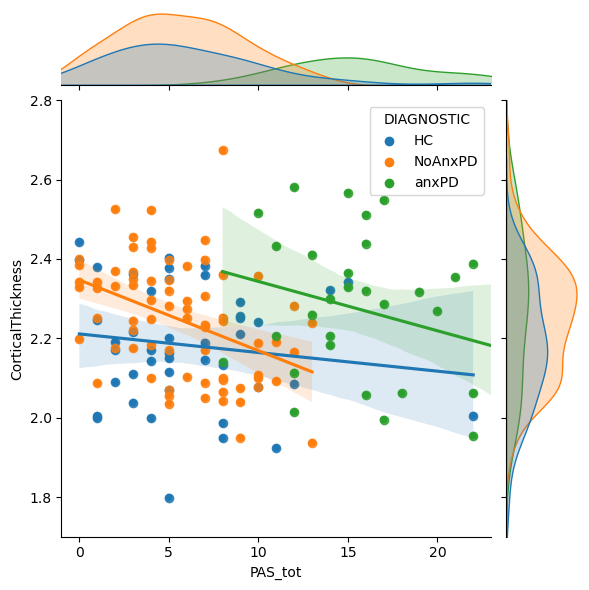

In [113]:
valCT=[]
valPAS=[]
group=[]
for elt in val.iterrows():
    path_file_lh=os.path.join(STUDY_DIR,"bids_data","derivatives_wCorrectedFS","micapipe_v0.2.0",str(elt[0]),"ses-1","maps",str(elt[0])+"_ses-1_hemi-L_surf-fsLR-32k_label-thickness.func.gii")
    path_file_rh=os.path.join(STUDY_DIR,"bids_data","derivatives_wCorrectedFS","micapipe_v0.2.0",str(elt[0]),"ses-1","maps",str(elt[0])+"_ses-1_hemi-R_surf-fsLR-32k_label-thickness.func.gii")
    if os.path.exists(path_file_lh) and os.path.exists(path_file_rh):
        tmp_rh=nib.load(path_file_rh) 
        tmp_lh=nib.load(path_file_lh)        
        volumeG1 = np.concatenate([tmp_lh.darrays[0].data,tmp_rh.darrays[0].data], axis=0)
        valCT.append(np.mean(volumeG1[ind[0]]))
        valPAS.append(elt[1]["PAS_tot"])
        group.append(elt[1]["GROUP_NAME"])
                
df = pd.DataFrame({'CorticalThickness': valCT, 'PAS_tot': valPAS,'DIAGNOSTIC':group})

mediane = df["CorticalThickness"].median()
iqr = df["CorticalThickness"].quantile(0.75) - df["CorticalThickness"].quantile(0.25)

lignes_a_supprimer = df[df["CorticalThickness"] > (mediane + 3 * iqr)].index
print("Nb pts > mediane + 3 IQR : ", len(lignes_a_supprimer))
df = df.drop(lignes_a_supprimer)
lignes_a_supprimer = df[df["CorticalThickness"] < (mediane - 3 * iqr)].index
df = df.drop(lignes_a_supprimer)
print("Nb pts < mediane + 3 IQR : ", len(lignes_a_supprimer))

#sns.jointplot(df,y="CorticalThickness",x="PAS_tot",kind="reg")
sns.jointplot(df,y="CorticalThickness",x="PAS_tot",hue="DIAGNOSTIC")
plt.gca().set_xlim([-1, 23])
plt.gca().set_ylim([1.7,2.8])
for diag in df["DIAGNOSTIC"].unique():
    sns.regplot(x="PAS_tot", y="CorticalThickness", data=df[df["DIAGNOSTIC"] == diag])

# Correlation analysis 

In [5]:
resV=[]
resF=[]
files = glob.glob(os.path.join(STUDY_DIR,"results","Palm_REG_*_GC_CT_*","results_CT_*_reg_dpv_tstat_*.gii"))
for file in files:
    lh_volume = [x.data for x in nib.load(file).darrays] 
    resF.append(file.split('/')[6:8])
    resV.append(round(np.max(lh_volume[0]),2))
    #print(file.split('/')[6:8],round(np.max(lh_volume[0]),2))
    
print("Maximum value of ftest (-log(p)) , smoothing X mm ex: Palm_4_GC_F_CT_X_Anxiety, side (R/L) with or without covariables (wCov/woCov), with or without correction (fwep/uncp)")  
val_sorted=sorted(zip(resV,resF),reverse=True)
val_sorted

Maximum value of ftest (-log(p)) , smoothing X mm ex: Palm_4_GC_F_CT_X_Anxiety, side (R/L) with or without covariables (wCov/woCov), with or without correction (fwep/uncp)


[(4.72, ['Palm_REG_4_GC_CT_4_PD', 'results_CT_R_reg_dpv_tstat_uncp.gii']),
 (4.72, ['Palm_REG_4_GC_CT_4_PD', 'results_CT_L_reg_dpv_tstat_uncp.gii']),
 (4.54, ['Palm_REG_4_GC_CT_4_NoAnxPD', 'results_CT_R_reg_dpv_tstat_uncp.gii']),
 (4.16,
  ['Palm_REG_4_GC_CT_4_Anxiety_HC', 'results_CT_R_reg_dpv_tstat_uncp.gii']),
 (4.16,
  ['Palm_REG_4_GC_CT_4_Anxiety_HC', 'results_CT_L_reg_dpv_tstat_uncp.gii']),
 (3.76, ['Palm_REG_4_GC_CT_8_NoAnxPD', 'results_CT_R_reg_dpv_tstat_uncp.gii']),
 (3.76, ['Palm_REG_4_GC_CT_8_NoAnxPD', 'results_CT_L_reg_dpv_tstat_uncp.gii']),
 (3.74,
  ['Palm_REG_4_GC_CT_4_Anxiety_ALL', 'results_CT_R_reg_dpv_tstat_uncp.gii']),
 (3.74,
  ['Palm_REG_4_GC_CT_4_Anxiety_ALL', 'results_CT_L_reg_dpv_tstat_uncp.gii']),
 (3.67,
  ['Palm_REG_4_GC_CT_8_Anxiety_HC', 'results_CT_R_reg_dpv_tstat_uncp.gii']),
 (3.67,
  ['Palm_REG_4_GC_CT_8_Anxiety_HC', 'results_CT_L_reg_dpv_tstat_uncp.gii']),
 (2.94, ['Palm_REG_4_GC_CT_8_PD', 'results_CT_R_reg_dpv_tstat_uncp.gii']),
 (2.94, ['Palm_REG_4_GC

Text(0.5, 1.0, 'Correlation between Cortical thickness and PAS score for All patients')

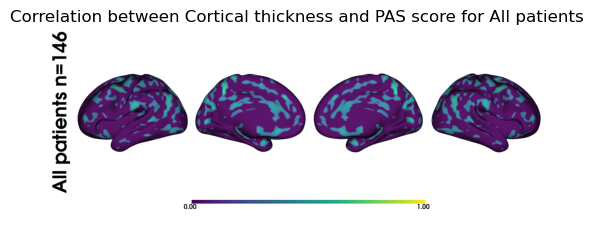

In [12]:
lh_file=os.path.join(STUDY_DIR,"results","Palm_REG_4_GC_CT_8_Anxiety_ALL","results_CT_L_reg_tfce_tstat_uncp.gii")
#/NAS/coolio/protocoles/Track_PD_DTA/results/Palm_REG_4_GC_CT_10_Anxiety/results_CT_L_reg_tfce_tstat_fwep.gii
lh_volume = [x.data for x in nib.load(lh_file).darrays] 

rh_file=os.path.join(STUDY_DIR,"results","Palm_REG_4_GC_CT_8_Anxiety_ALL","results_CT_R_reg_tfce_tstat_uncp.gii")
rh_volume = [x.data for x in nib.load(rh_file).darrays]

volumeG1 = np.concatenate([lh_volume[0],rh_volume[0]], axis=0)

tmp=nib.load(os.path.join(STUDY_DIR,"results","Palm_REG_4_GC_CT_8_Anxiety_ALL","CT.L_sm8.func.gii"))
n_G1=len(tmp.darrays)

labels = ['All patients n='+str(n_G1)]
figure_title=os.path.join(STUDY_DIR,"results","cor_CT_PAS_tot.png")

plot_hemispheres(lh_surface_data, rh_surface_data,array_name=[volumeG1],size=(1200,450),label_text=labels,zoom=1.2,nan_color=(0, 0, 0, 1),transparent_bg=False, embed_nb=True,share='both',screenshot=True, offscreen=True,filename=figure_title,interactive=True,color_range=(0,1),color_bar='bottom')

image = plt.imread(figure_title)
#fig=plt.figure(figsize=figsize)
fig=plt.imshow(image)
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.title('Correlation between Cortical thickness and PAS score for All patients')
#pdf.savefig()

Text(0.5, 1.0, 'Correlation between Cortical thickness and PAS score for PD patients')

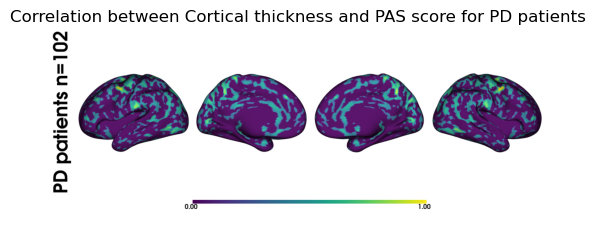

In [13]:
lh_file=os.path.join(STUDY_DIR,"results","Palm_REG_4_GC_CT_4_PD","results_CT_L_reg_tfce_tstat_uncp.gii")
#/NAS/coolio/protocoles/Track_PD_DTA/results/Palm_REG_4_GC_CT_10_Anxiety/results_CT_L_reg_tfce_tstat_fwep.gii
lh_volume = [x.data for x in nib.load(lh_file).darrays] 

rh_file=os.path.join(STUDY_DIR,"results","Palm_REG_4_GC_CT_4_PD","results_CT_R_reg_tfce_tstat_uncp.gii")
rh_volume = [x.data for x in nib.load(rh_file).darrays]

volumeG1 = np.concatenate([lh_volume[0],rh_volume[0]], axis=0)

tmp=nib.load(os.path.join(STUDY_DIR,"results","Palm_REG_4_GC_CT_4_PD","CT.L_sm4.func.gii"))
n_G1=len(tmp.darrays)

labels = ['PD patients n='+str(n_G1)]
figure_title=os.path.join(STUDY_DIR,"results","cor_CT_PAS_PD.png")

plot_hemispheres(lh_surface_data, rh_surface_data,array_name=[volumeG1],size=(1200,450),label_text=labels,zoom=1.2,nan_color=(0, 0, 0, 1),transparent_bg=False, embed_nb=True,share='both',screenshot=True, offscreen=True,filename=figure_title,interactive=True,color_range=(0,1),color_bar='bottom')

image = plt.imread(figure_title)
#fig=plt.figure(figsize=figsize)
fig=plt.imshow(image)
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.title('Correlation between Cortical thickness and PAS score for PD patients')
#pdf.savefig()

Text(0.5, 1.0, 'Correlation between Cortical thickness and PAS score for Non-Anx PD patients')

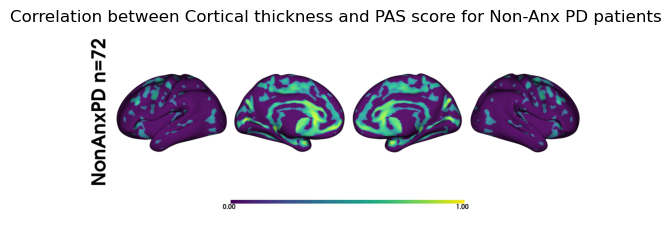

In [16]:
lh_file=os.path.join(STUDY_DIR,"results","Palm_REG_4_GC_CT_8_NoAnxPD","results_CT_L_reg_tfce_tstat_uncp.gii")
#/NAS/coolio/protocoles/Track_PD_DTA/results/Palm_REG_4_GC_CT_10_Anxiety/results_CT_L_reg_tfce_tstat_fwep.gii
lh_volume = [x.data for x in nib.load(lh_file).darrays] 

rh_file=os.path.join(STUDY_DIR,"results","Palm_REG_4_GC_CT_8_NoAnxPD","results_CT_R_reg_tfce_tstat_uncp.gii")
rh_volume = [x.data for x in nib.load(rh_file).darrays]

volumeG1 = np.concatenate([lh_volume[0],rh_volume[0]], axis=0)

tmp=nib.load(os.path.join(STUDY_DIR,"results","Palm_REG_4_GC_CT_8_NoAnxPD","CT.L_sm8.func.gii"))
n_G1=len(tmp.darrays)

labels = ['NonAnxPD n='+str(n_G1)]
figure_title=os.path.join(STUDY_DIR,"results","cor_CT_PAS_NonAnxPD.png")

plot_hemispheres(lh_surface_data, rh_surface_data,array_name=[volumeG1],size=(1200,450),label_text=labels,zoom=1.2,nan_color=(0, 0, 0, 1),transparent_bg=False, embed_nb=True,share='both',screenshot=True, offscreen=True,filename=figure_title,interactive=True,color_range=(0,1),color_bar='bottom')

image = plt.imread(figure_title)
#fig=plt.figure(figsize=figsize)
fig=plt.imshow(image)
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.title('Correlation between Cortical thickness and PAS score for Non-Anx PD patients')
#pdf.savefig()

Text(0.5, 1.0, 'Correlation between Cortical thickness and PAS score for Anx patient')

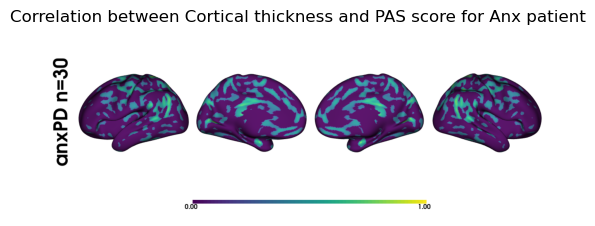

In [32]:
lh_file=os.path.join(STUDY_DIR,"results","Palm_REG_4_GC_CT_8_anxPD","results_CT_L_reg_tfce_tstat_uncp.gii")
#/NAS/coolio/protocoles/Track_PD_DTA/results/Palm_REG_4_GC_CT_10_Anxiety/results_CT_L_reg_tfce_tstat_fwep.gii
lh_volume = [x.data for x in nib.load(lh_file).darrays] 

rh_file=os.path.join(STUDY_DIR,"results","Palm_REG_4_GC_CT_8_anxPD","results_CT_R_reg_tfce_tstat_uncp.gii")
rh_volume = [x.data for x in nib.load(rh_file).darrays]

volumeG1 = np.concatenate([lh_volume[0],rh_volume[0]], axis=0)

tmp=nib.load(os.path.join(STUDY_DIR,"results","Palm_REG_4_GC_CT_8_anxPD","CT.L_sm8.func.gii"))
n_G1=len(tmp.darrays)

labels = ['anxPD n='+str(n_G1)]
figure_title=os.path.join(STUDY_DIR,"results","cor_CT_PAS_AnxPD.png")

plot_hemispheres(lh_surface_data, rh_surface_data,array_name=[volumeG1],size=(1200,450),label_text=labels,zoom=1.2,nan_color=(0, 0, 0, 1),transparent_bg=False, embed_nb=True,share='both',screenshot=True, offscreen=True,filename=figure_title,interactive=True,color_range=(0,1),color_bar='bottom')

image = plt.imread(figure_title)
#fig=plt.figure(figsize=figsize)
fig=plt.imshow(image)
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.title('Correlation between Cortical thickness and PAS score for Anx patient')
#pdf.savefig()

Text(0.5, 1.0, 'Correlation between Cortical thickness and PAS score for HC')

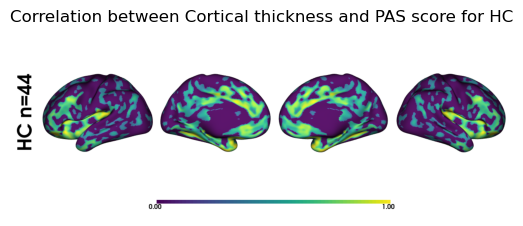

In [33]:
lh_file=os.path.join(STUDY_DIR,"results","Palm_REG_4_GC_CT_8_Anxiety_HC","results_CT_L_reg_tfce_tstat_uncp.gii")
#/NAS/coolio/protocoles/Track_PD_DTA/results/Palm_REG_4_GC_CT_10_Anxiety/results_CT_L_reg_tfce_tstat_fwep.gii
lh_volume = [x.data for x in nib.load(lh_file).darrays] 

rh_file=os.path.join(STUDY_DIR,"results","Palm_REG_4_GC_CT_8_Anxiety_HC","results_CT_R_reg_tfce_tstat_uncp.gii")
rh_volume = [x.data for x in nib.load(rh_file).darrays]

volumeG1 = np.concatenate([lh_volume[0],rh_volume[0]], axis=0)

tmp=nib.load(os.path.join(STUDY_DIR,"results","Palm_REG_4_GC_CT_8_Anxiety_HC","CT.L_sm8.func.gii"))
n_G1=len(tmp.darrays)
labels = ['HC n='+str(n_G1)]
figure_title=os.path.join(STUDY_DIR,"results","cor_CT_PAS_HC.png")

plot_hemispheres(lh_surface_data, rh_surface_data,array_name=[volumeG1],size=(1200,450),label_text=labels,zoom=1.2,nan_color=(0, 0, 0, 1),transparent_bg=False, embed_nb=True,share='both',screenshot=True, offscreen=True,filename=figure_title,interactive=True,color_range=(0,1),color_bar='bottom')

image = plt.imread(figure_title)
#fig=plt.figure(figsize=figsize)
fig=plt.imshow(image)
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.title('Correlation between Cortical thickness and PAS score for HC')
#pdf.savefig()

In [36]:
lh_file= os.path.join(STUDY_DIR,"results","Palm_REG_4_GC_CT_8_Anxiety_ALL","results_CT_L_reg_tfce_tstat_uncp.gii")
lh_volume = [x.data for x in nib.load(lh_file).darrays] 
rh_file= os.path.join(STUDY_DIR,"results","Palm_REG_4_GC_CT_8_Anxiety_ALL","results_CT_R_reg_tfce_tstat_uncp.gii")
rh_volume = [x.data for x in nib.load(rh_file).darrays] 
G5 = np.concatenate([lh_volume[0],rh_volume[0]], axis=0)
print("ALL : ",np.max(G5))

lh_file= os.path.join(STUDY_DIR,"results","Palm_REG_4_GC_CT_8_anxPD","results_CT_L_reg_tfce_tstat_uncp.gii")
lh_volume = [x.data for x in nib.load(lh_file).darrays] 
rh_file= os.path.join(STUDY_DIR,"results","Palm_REG_4_GC_CT_8_anxPD","results_CT_R_reg_tfce_tstat_uncp.gii")
rh_volume = [x.data for x in nib.load(rh_file).darrays] 
G4 = np.concatenate([lh_volume[0],rh_volume[0]], axis=0)
print("Anx : ",np.max(G4))


lh_file=os.path.join(STUDY_DIR,"results","Palm_REG_4_GC_CT_8_Anxiety_HC","results_CT_L_reg_tfce_tstat_uncp.gii")
lh_volume = [x.data for x in nib.load(lh_file).darrays] 
rh_file=os.path.join(STUDY_DIR,"results","Palm_REG_4_GC_CT_8_Anxiety_HC","results_CT_R_reg_tfce_tstat_uncp.gii")
rh_volume = [x.data for x in nib.load(rh_file).darrays]
G3 = np.concatenate([lh_volume[0],rh_volume[0]], axis=0)
print("HC : ",np.max(G3))

#NoAnx
lh_file=os.path.join(STUDY_DIR,"results","Palm_REG_4_GC_CT_8_NoAnxPD","results_CT_L_reg_tfce_tstat_uncp.gii")
lh_volume = [x.data for x in nib.load(lh_file).darrays] 
rh_file=os.path.join(STUDY_DIR,"results","Palm_REG_4_GC_CT_8_NoAnxPD","results_CT_R_reg_tfce_tstat_uncp.gii")
rh_volume = [x.data for x in nib.load(rh_file).darrays]
G2 = np.concatenate([lh_volume[0],rh_volume[0]], axis=0)
print("NonAnx : ",np.max(G2))

#PD
lh_file=os.path.join(STUDY_DIR,"results","Palm_REG_4_GC_CT_4_PD","results_CT_L_reg_tfce_tstat_uncp.gii")
lh_volume = [x.data for x in nib.load(lh_file).darrays] 
rh_file=os.path.join(STUDY_DIR,"results","Palm_REG_4_GC_CT_4_PD","results_CT_R_reg_tfce_tstat_uncp.gii")
rh_volume = [x.data for x in nib.load(rh_file).darrays]
G1 = np.concatenate([lh_volume[0],rh_volume[0]], axis=0)
print("PD : ",np.max(G1))

ALL :  0.7508016
Anx :  0.9511699
HC :  1.1169066
NonAnx :  0.9389247
PD :  1.0357404


In [ ]:
valCT=[]
valPAS=[]
group=[]
for elt in val.iterrows():
    path_file_lh=os.path.join(STUDY_DIR,"bids_data","derivatives","micapipe_v0.2.0",str(elt[0]),"ses-1","maps",str(elt[0])+"_ses-1_hemi-L_surf-fsLR-32k_label-thickness.func.gii")
    path_file_rh=os.path.join(STUDY_DIR,"bids_data","derivatives","micapipe_v0.2.0",str(elt[0]),"ses-1","maps",str(elt[0])+"_ses-1_hemi-R_surf-fsLR-32k_label-thickness.func.gii")
    if os.path.exists(path_file_lh) and os.path.exists(path_file_rh):
        tmp_rh=nib.load(path_file_rh) 
        tmp_lh=nib.load(path_file_lh)        
        volumeG1 = np.concatenate([tmp_lh.darrays[0].data,tmp_rh.darrays[0].data], axis=0)
        valCT.append(np.mean(volumeG1[ind]))
        valPAS.append(elt[1]["PAS_tot"])
        group.append(elt[1]["GROUP_NAME"])
                
df = pd.DataFrame({'CorticalThickness': valCT, 'PAS_tot': valPAS,'DIAGNOSTIC':group})

mediane = df["CorticalThickness"].median()
iqr = df["CorticalThickness"].quantile(0.75) - df["CorticalThickness"].quantile(0.25)
df = df.loc[df["CorticalThickness"] <= (mediane + 3 * iqr)]

#sns.jointplot(df,y="PAS_tot",x="CorticalThickness",kind="reg")
sns.jointplot(df.dropna(),y="PAS_tot",x="CorticalThickness",hue="DIAGNOSTIC")
plt.gca().set_xlim([0,np.max(df.dropna()["CorticalThickness"])])
plt.gca().set_ylim([-1, 23])

# Ajouter une droite de régression à chaque hue
for diag in df["DIAGNOSTIC"].unique():
    sns.regplot(x="CorticalThickness", y="PAS_tot", data=df[df["DIAGNOSTIC"] == diag])

plt.title('Correlation of cortical thickness with PAS score (by group) on suface cluster')
pdf.savefig()

# Comparison of corrected FS and non-corrected FS

In [54]:
file=os.path.join("/NAS","coolio","protocoles","Track_PD_DTA","CT_FScorr_Lside.csv")
CT_FScorr_LSide_df = pd.read_csv(file,index_col=0)
CT_FScorr_LSide_df = CT_FScorr_LSide_df.add_suffix("_lh")

file=os.path.join("/NAS","coolio","protocoles","Track_PD_DTA","CT_FScorr_Rside.csv")
CT_FScorr_RSide_df = pd.read_csv(file,index_col=0)
CT_FScorr_RSide_df = CT_FScorr_RSide_df.add_suffix("_rh")

file=os.path.join("/NAS","coolio","protocoles","Track_PD_DTA","CT_FSnoncorr_Lside_micapipe.csv")
CT_FSnoncorr_LSide_mica_df = pd.read_csv(file,index_col=0)
CT_FSnoncorr_LSide_mica_df = CT_FSnoncorr_LSide_mica_df.add_suffix("_lh")

file=os.path.join("/NAS","coolio","protocoles","Track_PD_DTA","CT_FSnoncorr_Rside_micapipe.csv")
CT_FSnoncorr_RSide_mica_df = pd.read_csv(file,index_col=0)
CT_FSnoncorr_RSide_mica_df = CT_FSnoncorr_RSide_mica_df.add_suffix("_rh")

df_FScorr = pd.concat([CT_FScorr_LSide_df, CT_FScorr_RSide_df], axis=1,join="inner")
df_FSnoncorr = pd.concat([CT_FSnoncorr_LSide_mica_df, CT_FSnoncorr_RSide_mica_df], axis=1,join="inner")

print(len(set(df_FScorr.index) & set(df_FSnoncorr.index)))

_=plt.plot(df_FSnoncorr.values,df_FScorr.loc[df_FSnoncorr.index].values,".")
x_values = range(1,5)
y_values = [x for x in x_values]
plt.plot(x_values, y_values, label='y = x')

sns.histplot(val,x="Age",bins=10)

In [6]:
files = glob.glob(os.path.join(STUDY_DIR,"results","Palm_CORR_4_CT_*_AGE","results_CT_*_reg_tfce_tstat_*.gii"))
for file in files:
    lh_volume = [x.data for x in nib.load(file).darrays] 
    print(file,round(np.max(lh_volume[0]),2))

NameError: name 'glob' is not defined

In [18]:
#pdf.close() 

# BRAINSTAT
https://brainstat.readthedocs.io/en/master/python/tutorials/tutorial_1.html#python-tutorial1

In [9]:
#!pip install brainstat

from brainstat.datasets import fetch_mask, fetch_template_surface
from brainstat.tutorial.utils import fetch_mics_data
from brainstat.stats.terms import FixedEffect
import numpy as np
from brainspace.plotting import plot_hemispheres
from brainstat.stats.SLM import SLM
from brainstat.datasets import fetch_parcellation
from nilearn.surface import surface
import matplotlib.pyplot as plt

from brainstat.context.meta_analysis import meta_analytic_decoder
from wordcloud import WordCloud

In [507]:
pial_left, pial_right = fetch_template_surface("fsaverage5", join=False)
pial_combined = fetch_template_surface("fsaverage5", join=True)
mask = fetch_mask("fsaverage5")

fs5_lh,fs5_rh = fetch_template_surface("fsaverage5", join=False,layer="inflated")
yeo_networks = fetch_parcellation("fsaverage5", "yeo", 7)
glasser = fetch_parcellation("fsaverage5", "glasser", 360)
fwhm=10


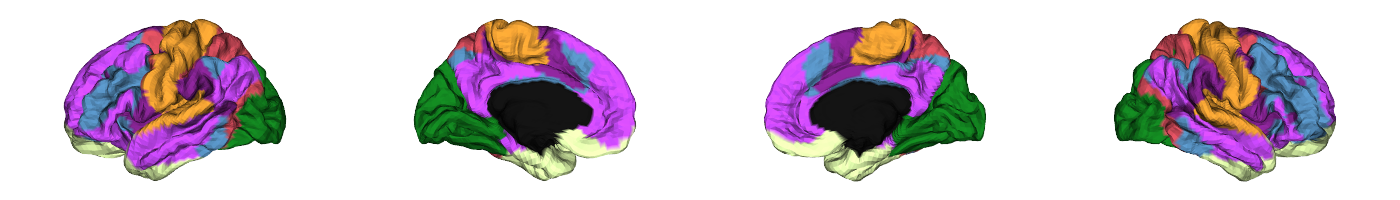

In [508]:
plot_hemispheres(pial_left, pial_right,
    yeo_networks,
    embed_nb=True,
    cmap="yeo7",
    nan_color=(0.7, 0.7, 0.7, 1),
    size=(1400, 200),
    zoom=1.45,
)

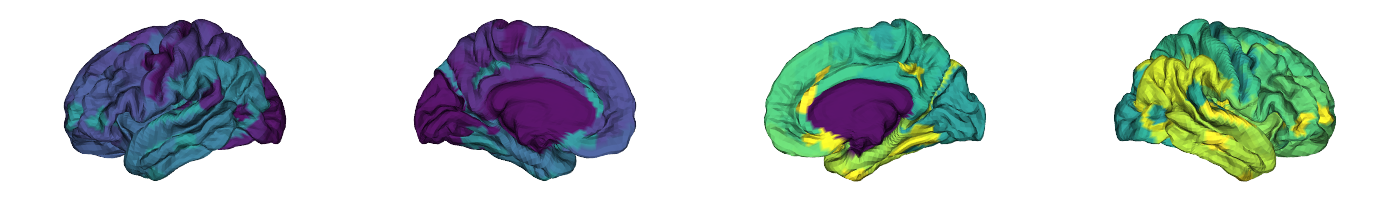

In [509]:
plot_hemispheres(pial_left, pial_right,
    glasser,
    embed_nb=True,
    nan_color=(0.7, 0.7, 0.7, 1),
    size=(1400, 200),
    zoom=1.45,
)

In [510]:
valCT=[]
valPAS=[]
group=[]
for elt in val.iterrows():
    path_file_lh=os.path.join(DERIVATIVE_DIR_DIR,"micapipe_v0.2.0",str(elt[0]),"ses-1","maps",str(elt[0])+"_ses-1_hemi-L_surf-fsaverage5_label-thickness_sm5.func.gii")
    path_file_rh=os.path.join(DERIVATIVE_DIR_DIR,"micapipe_v0.2.0",str(elt[0]),"ses-1","maps",str(elt[0])+"_ses-1_hemi-R_surf-fsaverage5_label-thickness_sm5.func.gii")
    if os.path.exists(path_file_lh) and os.path.exists(path_file_rh):
        tmp_rh=nib.load(path_file_rh) 
        tmp_lh=nib.load(path_file_lh)
        volumeG1 = np.concatenate([tmp_lh.darrays[0].data,tmp_rh.darrays[0].data], axis=0)
        valCT.append(volumeG1)
        valPAS.append(elt[1]["PAS_tot"])
        group.append(elt[1]["GROUP_NAME"])
    else :
        print(str(elt[0]))
        val=val.drop(str(elt[0]))

print(thickness.shape)
thickness=np.array(valCT)

(146, 20484)


In [511]:
val['Sex']=val['Sex'].replace({1:'M',0:'F'})
val['GROUP_NAME_FUS']=val['GROUP_NAME'].replace({'NoAnxPD':'NoAnx','HC':'NoAnx'})

In [512]:
val['GROUP_NAME_PDvsHC']=val['GROUP_NAME'].replace({'NoAnxPD':'PD','AnxPD':'PD'})

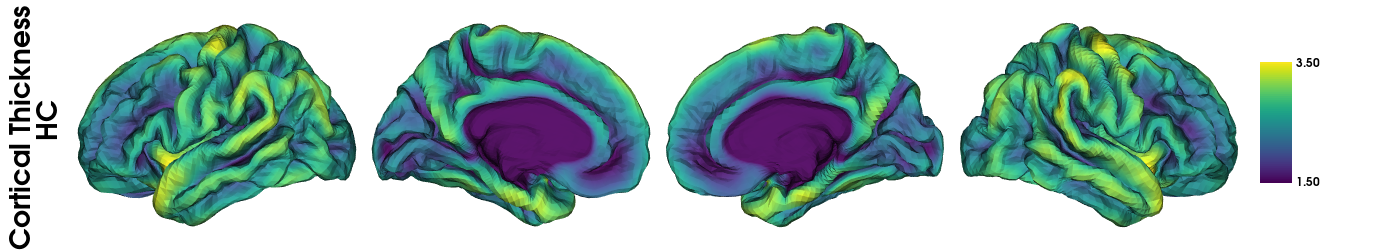

In [513]:
plot_hemispheres(pial_left, pial_right, np.mean(thickness[val['GROUP_NAME']=="HC"], axis=0), color_bar=True, color_range=(1.5, 3.5),
        label_text=["Cortical Thickness \n HC"], cmap="viridis", embed_nb=True, size=(1400, 250), zoom=1.45,
        nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, interactive=False,transparent_bg=False)

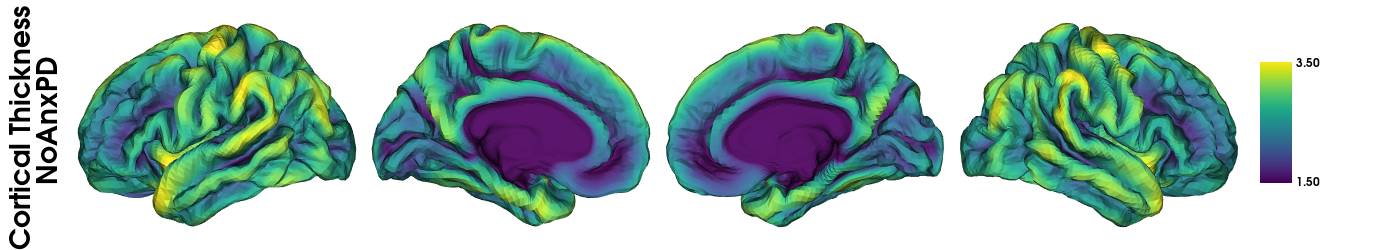

In [514]:
plot_hemispheres(pial_left, pial_right, np.mean(thickness[val['GROUP_NAME']=="NoAnxPD"], axis=0), color_bar=True, color_range=(1.5, 3.5),
        label_text=["Cortical Thickness \n NoAnxPD"], cmap="viridis", embed_nb=True, size=(1400, 250), zoom=1.45,
        nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, interactive=False,transparent_bg=False)

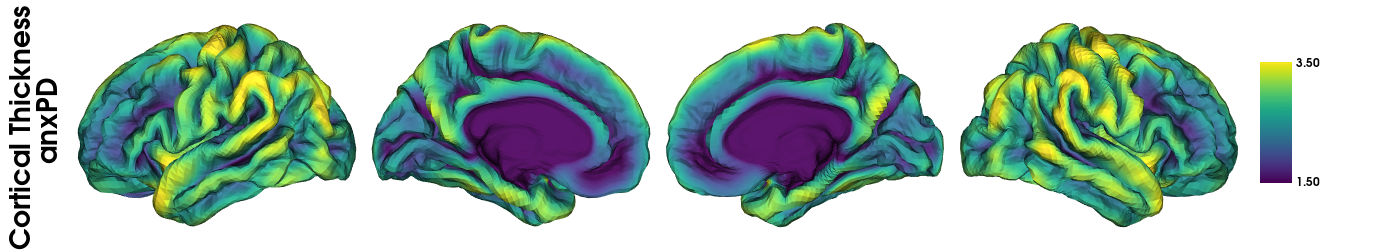

In [515]:
plot_hemispheres(pial_left, pial_right, np.mean(thickness[val['GROUP_NAME']=="anxPD"], axis=0), color_bar=True, color_range=(1.5, 3.5),
        label_text=["Cortical Thickness \n anxPD"], cmap="viridis", embed_nb=True, size=(1400, 250), zoom=1.45,
        nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, interactive=False,transparent_bg=False)

In [516]:
term_age = FixedEffect(val.Age)
model_age = term_age
term_pas = FixedEffect(val.PAS_tot)
model_pas = term_pas
term_group = FixedEffect(val.GROUP_NAME_FUS)
model_group = term_group
contrast_group = (val.GROUP_NAME_FUS == "NoAnx").astype(int) - (val.GROUP_NAME_FUS == "NoAnxPD").astype(
    int
)
indices_PD=val[val['GROUP_NAME']!="HC"].index
indices_NonAnx=val[val['GROUP_NAME']!="anxPD"].index

In [517]:
contrast_pas = val.PAS_tot
slm_pas = SLM(
    model_pas,
    contrast_pas,
    surf="fsaverage5",
    mask=mask,
    correction=["fdr", "rft"],
    cluster_threshold=0.01,
)
slm_pas.fit(thickness)

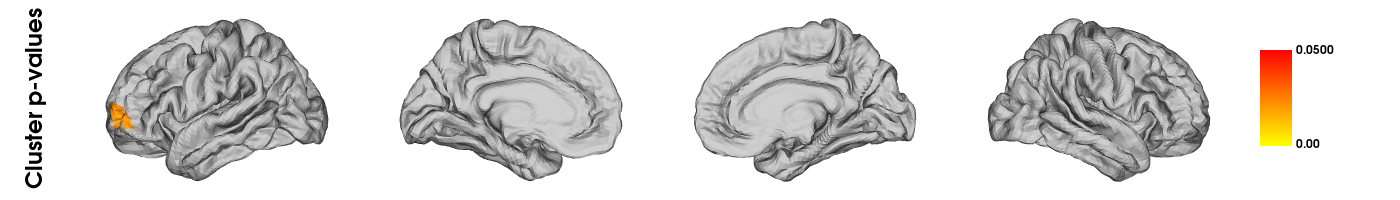

In [518]:
cp = [np.copy(slm_pas.P["pval"]["C"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in cp]

plot_hemispheres(pial_left, pial_right, cp[0].T, color_bar=True, color_range=(0, 0.05),
        label_text=["Cluster p-values"], cmap="autumn_r", embed_nb=True, size=(1400, 200), 
        zoom=1.45, nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, 
        interactive=False,transparent_bg=False)

In [489]:
slm_pas.P['peak']

[          t  vertid  clusid          P               yeo7
 0  2.695242   13072       1  10.944944  Ventral Attention
 1  2.365298   14080       2  21.294829        Somatomotor,
            t  vertid  clusid          P               yeo7
 0   3.530750    5118       3   1.272692  Ventral Attention
 1   3.458507   17574      15   1.570703     Frontoparietal
 2   3.455568   15387      12   1.584643             Visual
 3   3.391705    3309       2   1.902013   Dorsal Attention
 4   3.339603    2912       8   2.201910        Somatomotor
 ..       ...     ...     ...        ...                ...
 44  2.515292    4695      35  15.955364       Default mode
 45  2.501879   15990      33  16.385872       Default mode
 46  2.456432    4723      13  17.918448       Default mode
 47  2.440643    2260      37  18.473471  Ventral Attention
 48  2.429655     907      36  18.865854        Somatomotor
 
 [49 rows x 5 columns]]

In [523]:
slm_pas.P['clus'][1]

clusid  nverts    resels         P
0        1    87.0  2.919678  0.011173
1        2    26.0  1.613015  0.239926
2        3    24.0  1.437719  0.349448
3        4    27.0  1.397306  0.379492
4        5    24.0  1.020249  0.722278
..     ...     ...       ...       ...
34      35     2.0  0.102578  1.000000
35      36     3.0  0.088811  1.000000
36      37     5.0  0.071766  1.000000
37      38     3.0  0.066608  1.000000
38      39     2.0  0.021621  1.000000

[39 rows x 4 columns]

2024-03-25 19:06:04,094 - brainstat - INFO - Fetching Neurosynth feature files. This may take several minutes if you haven't downloaded them yet.
2024-03-25 19:06:04,170 - brainstat - INFO - Running correlations with all Neurosynth features.


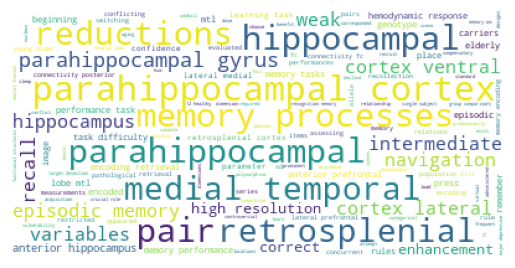

In [506]:
meta_analysis = meta_analytic_decoder("fsaverage5", cp[0].T.flatten())

wc = WordCloud(background_color="white", random_state=0)
wc.generate_from_frequencies(frequencies=meta_analysis.to_dict()["Pearson's r"])
plt.imshow(wc)
plt.axis("off")
plt.show()

cluster1


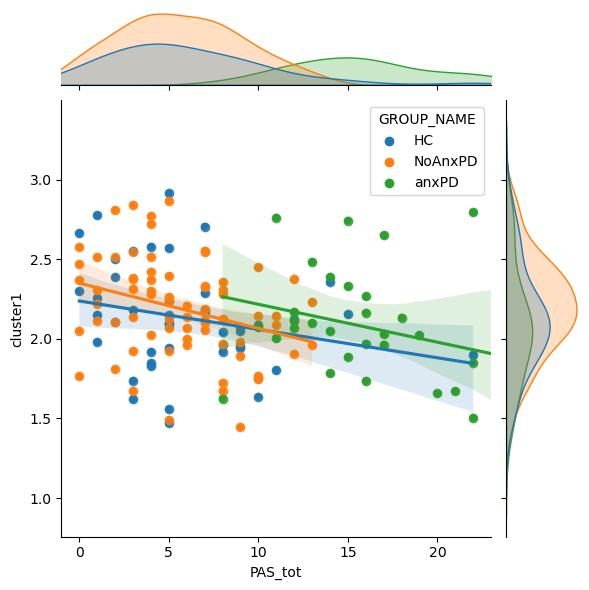

In [503]:
new_val=val
cpt=1
name="cluster"+str(cpt)
print(name)

#peaks=slm_grouppas.P["peak"][0][slm_grouppas.P["peak"][0]["clusid"]==cpt]["vertid"].values
#print(yeo_networks[peaks[0]])
inds=np.where(slm_pas.P['clusid'][1]==cpt)[1]
valCTperclust=np.mean(thickness[:,inds],1)
new_val[name]=valCTperclust
mediane = new_val[name].median()
iqr = new_val[name].quantile(0.75) - new_val[name].quantile(0.25)

#sns.jointplot(df,y="CorticalThickness",x="PAS_tot",kind="reg")
sns.jointplot(new_val,y=name,x="PAS_tot",hue="GROUP_NAME")
plt.gca().set_xlim([-1, 23])
#plt.gca().set_ylim([1.7,2.8])
for diag in new_val["GROUP_NAME"].unique():
    sns.regplot(x="PAS_tot", y=name, data=new_val[new_val["GROUP_NAME"] == diag])

In [537]:
print(yeo_networks[slm_pas.P['peak'][0]['vertid'][0]])
print(glasser[slm_pas.P['peak'][0]['vertid'][0]])


4
238


# ANX vs NonAnx

In [473]:
model_grouppas = term_pas + term_group

slm_grouppas = SLM(
    model_grouppas,
    contrast_group,
    surf=pial_combined,
    mask=mask,
    correction=["fdr", "rft"],
    two_tailed=False,
    cluster_threshold=0.01,
)
slm_grouppas.fit(thickness)

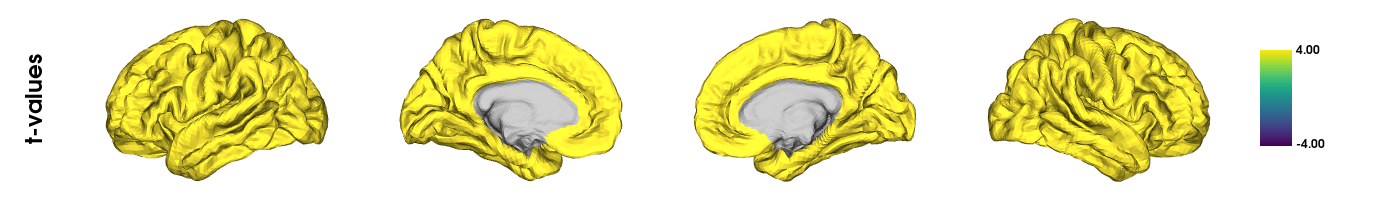

In [474]:
plot_hemispheres(pial_left, pial_right, slm_grouppas.t, color_bar=True, color_range=(-4, 4),
        label_text=["t-values"], cmap="viridis", embed_nb=True, size=(1400, 200), zoom=1.45,
        nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, interactive=False,transparent_bg=False)

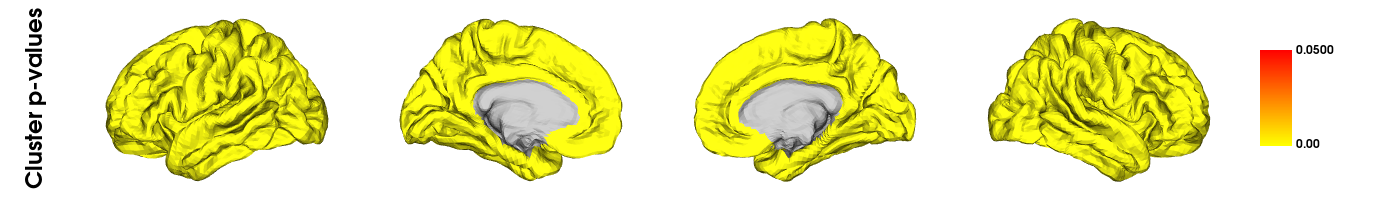

In [475]:
cp = [np.copy(slm_grouppas.P["pval"]["C"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in cp]

plot_hemispheres(pial_left, pial_right, cp[0].T, color_bar=True, color_range=(0, 0.05),
        label_text=["Cluster p-values"], cmap="autumn_r", embed_nb=True, size=(1400, 200), 
        zoom=1.45, nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, 
        interactive=False,transparent_bg=False)

# HC Vs. NonAnxPD

In [476]:
term_pas = FixedEffect(val[val['GROUP_NAME']!="anxPD"].PAS_tot)
model_pas = term_pas
term_group = FixedEffect(val[val['GROUP_NAME']!="anxPD"].GROUP_NAME)
model_group = term_group
contrast_group = (val[val['GROUP_NAME']!="anxPD"].GROUP_NAME == "HC").astype(int) - (val[val['GROUP_NAME']!="anxPD"].GROUP_NAME == "NoAnxPD").astype(
    int
)

model_grouppas = term_pas + term_group

slm_grouppas = SLM(
    model_grouppas,
    contrast_group,
    surf=pial_combined,
    mask=mask,
    correction=["fdr", "rft"],
    two_tailed=False,
    cluster_threshold=0.01,
)
slm_grouppas.fit(thickness[np.where(val['GROUP_NAME']!="anxPD")])

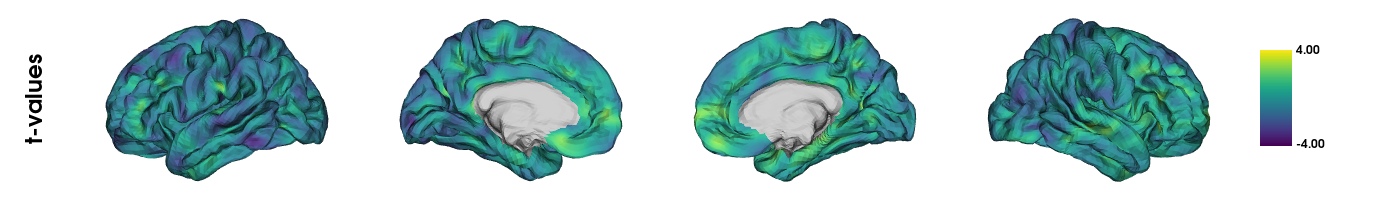

In [477]:
plot_hemispheres(pial_left, pial_right, slm_grouppas.t, color_bar=True, color_range=(-4, 4),
        label_text=["t-values"], cmap="viridis", embed_nb=True, size=(1400, 200), zoom=1.45,
        nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, interactive=False,transparent_bg=False)

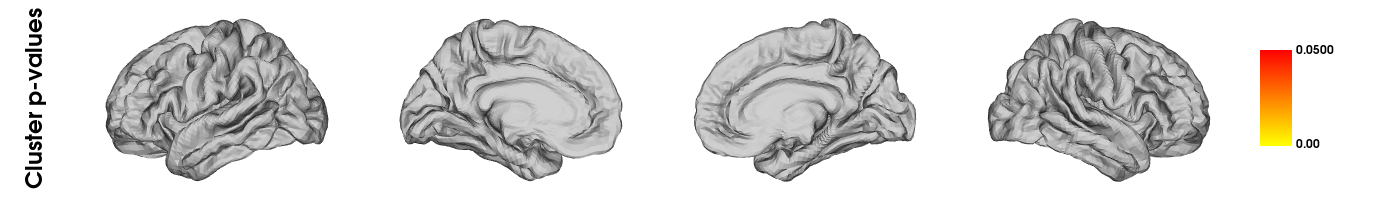

In [478]:
cp = [np.copy(slm_grouppas.P["pval"]["C"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in cp]

plot_hemispheres(pial_left, pial_right, cp[0].T, color_bar=True, color_range=(0, 0.05),
        label_text=["Cluster p-values"], cmap="autumn_r", embed_nb=True, size=(1400, 200), 
        zoom=1.45, nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, 
        interactive=False,transparent_bg=False)

# anxPD Vs. NonAnxPD

In [479]:
term_pas = FixedEffect(val[val['GROUP_NAME']!="HC"].PAS_tot)
model_pas = term_pas
term_group = FixedEffect(val[val['GROUP_NAME']!="HC"].GROUP_NAME)
model_group = term_group
contrast_group = (val[val['GROUP_NAME']!="HC"].GROUP_NAME == "anxPD").astype(int) - (val[val['GROUP_NAME']!="HC"].GROUP_NAME == "NoAnxPD").astype(
    int
)

model_grouppas = term_pas + term_group

slm_grouppas = SLM(
    model_grouppas,
    contrast_group,
    surf=pial_combined,
    mask=mask,
    correction=["fdr", "rft"],
    two_tailed=False,
    cluster_threshold=0.01,
)
slm_grouppas.fit(thickness[np.where(val['GROUP_NAME']!="HC")])

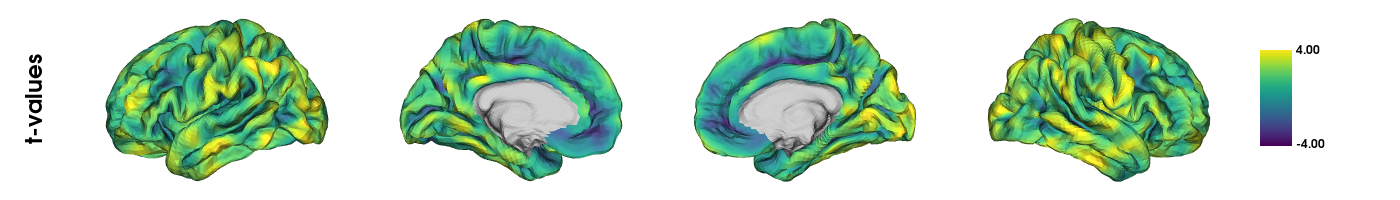

In [480]:
plot_hemispheres(pial_left, pial_right, slm_grouppas.t, color_bar=True, color_range=(-4, 4),
        label_text=["t-values"], cmap="viridis", embed_nb=True, size=(1400, 200), zoom=1.45,
        nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, interactive=False,transparent_bg=False)

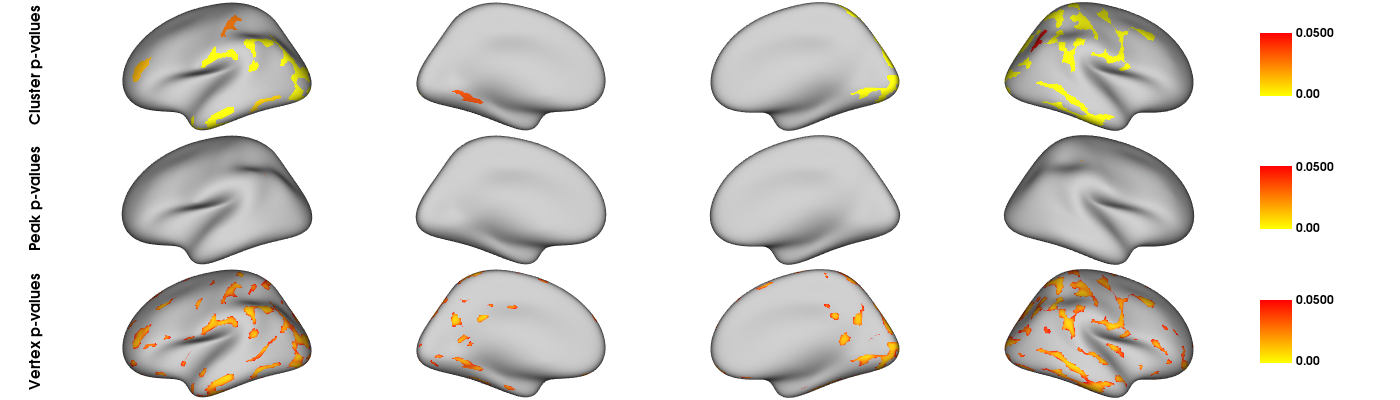

In [481]:
cp = [np.copy(slm_grouppas.P["pval"]["C"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in cp]

pp = [np.copy(slm_grouppas.P["pval"]["P"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in pp]

qp = [np.copy(slm_grouppas.Q)]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in qp]

vals = np.vstack([cp[0].T, pp[0].T, qp[0].T])

plot_hemispheres(fs5_lh, fs5_rh, vals, color_bar=True, color_range=(0, 0.05),
        label_text=["Cluster p-values", "Peak p-values", "Vertex p-values"], cmap="autumn_r", 
        embed_nb=True, size=(1400, 400), zoom=1.8, nan_color=(0.7, 0.7, 0.7, 1), 
        cb__labelTextProperty={"fontSize": 12}, interactive=False,transparent_bg=False)

In [482]:
cluster_onppeak=slm_grouppas.P["peak"][0][slm_grouppas.P["peak"][0]['P']<0.05]
cluster_onpcluster=slm_grouppas.P["clus"][0][(slm_grouppas.P["clus"][0]['nverts']>50) & (slm_grouppas.P["clus"][0]['P']<0.001)]
ind_peak=cluster_onppeak["clusid"].values
ind_clu=cluster_onpcluster["clusid"].values
clus_def=set(ind_peak) or set(ind_clu)

filt_array=np.where(np.isin(slm_grouppas.P["clusid"][0],list(clus_def)),slm_grouppas.P["clusid"][0],np.nan)
#slm_grouppas.P["clus"][0][inds]

In [483]:
cluster_onppeak

t  vertid  clusid         P
0  4.867162   16784       3  0.018660
1  4.749590    7325       1  0.028604
2  4.708982   13846       5  0.033096

In [484]:
cluster_onpcluster

clusid  nverts     resels         P
0       1   404.0  16.831079  0.000003
1       2   260.0  12.221643  0.000003
2       3   337.0  11.179562  0.000003
3       4   214.0  10.520101  0.000003
4       5   277.0   9.862530  0.000003
5       6   200.0   8.150625  0.000003
6       7   153.0   5.586797  0.000065
7       8   123.0   5.540629  0.000070
8       9   108.0   4.908904  0.000227

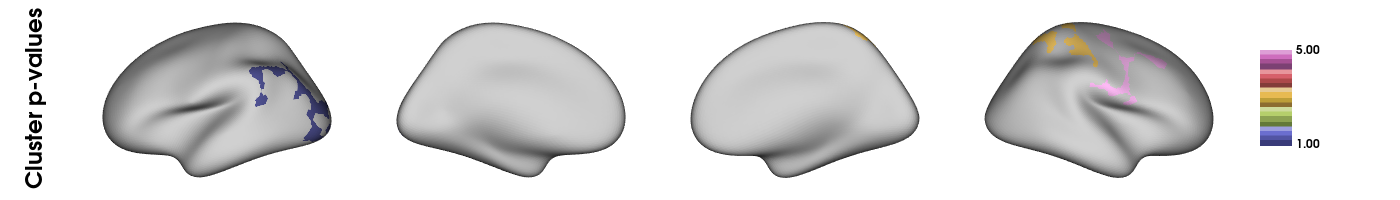

In [485]:
plot_hemispheres(fs5_lh, fs5_rh,filt_array, color_bar=True, 
        label_text=["Cluster p-values"],embed_nb=True, size=(1400, 200), cmap="tab20b",
        zoom=1.45, nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, 
        interactive=False,transparent_bg=False)

2024-03-25 18:36:45,150 - brainstat - INFO - Fetching Neurosynth feature files. This may take several minutes if you haven't downloaded them yet.
2024-03-25 18:36:45,261 - brainstat - INFO - Running correlations with all Neurosynth features.


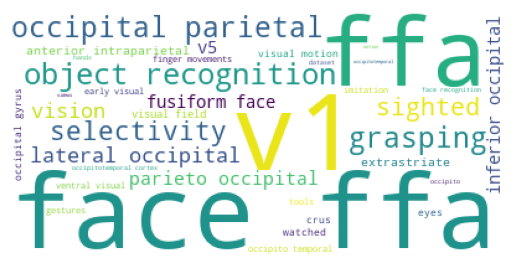

In [487]:
import matplotlib.pyplot as plt

from brainstat.context.meta_analysis import meta_analytic_decoder
from wordcloud import WordCloud

meta_analysis = meta_analytic_decoder("fsaverage5", slm_grouppas.t.flatten())

wc = WordCloud(background_color="white", random_state=0)
wc.generate_from_frequencies(frequencies=meta_analysis.to_dict()["Pearson's r"])
plt.imshow(wc)
plt.axis("off")
plt.show()

cluster1
cluster3
cluster5


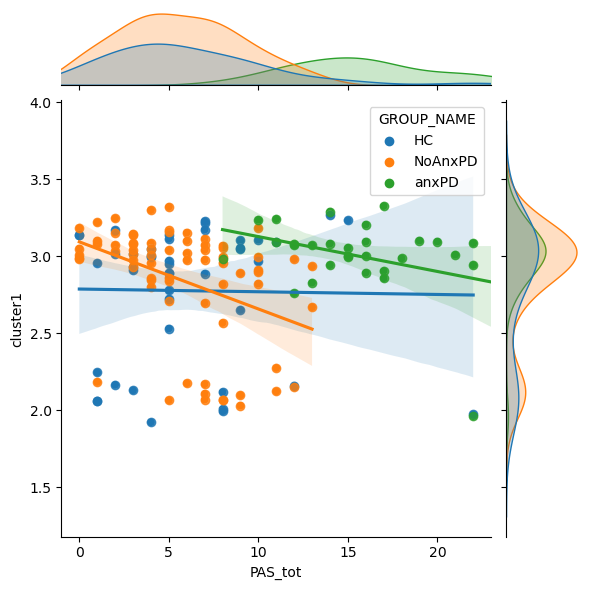

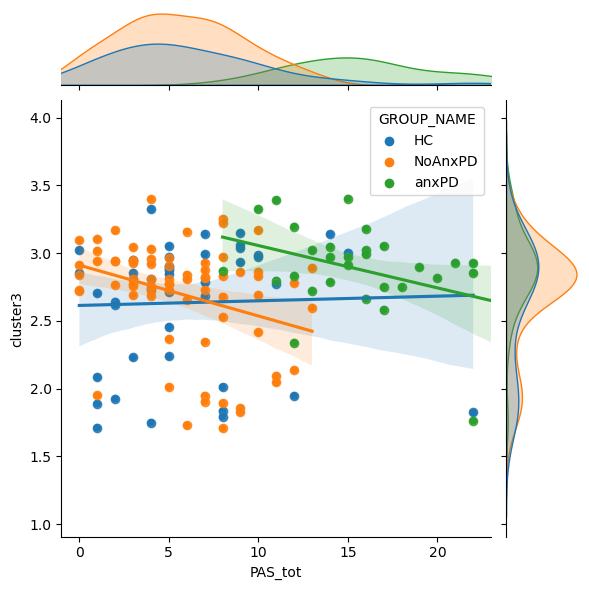

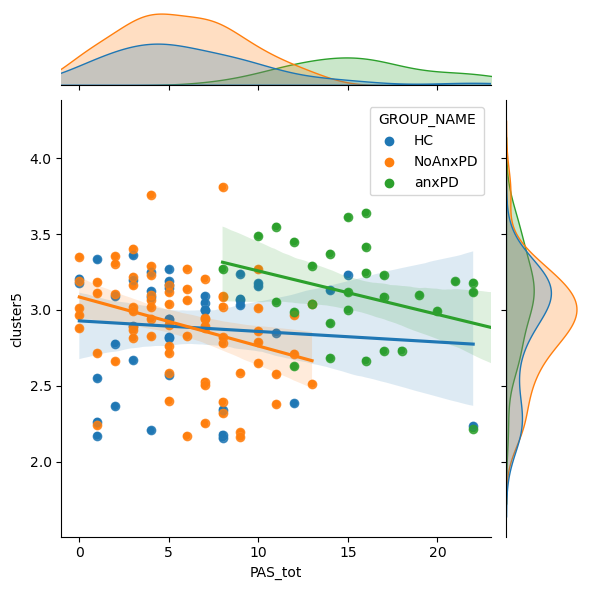

In [486]:
new_val=val
for cpt in list(clus_def) :
    name="cluster"+str(cpt)
    print(name)
    
    #peaks=slm_grouppas.P["peak"][0][slm_grouppas.P["peak"][0]["clusid"]==cpt]["vertid"].values
    #print(yeo_networks[peaks[0]])
    inds=np.where(slm_grouppas.P['clusid']==cpt)[2]
    valCTperclust=np.mean(thickness[:,inds],1)
    new_val[name]=valCTperclust
    mediane = new_val[name].median()
    iqr = new_val[name].quantile(0.75) - new_val[name].quantile(0.25)

    #sns.jointplot(df,y="CorticalThickness",x="PAS_tot",kind="reg")
    sns.jointplot(new_val,y=name,x="PAS_tot",hue="GROUP_NAME")
    plt.gca().set_xlim([-1, 23])
    #plt.gca().set_ylim([1.7,2.8])
    for diag in new_val["GROUP_NAME"].unique():
        sns.regplot(x="PAS_tot", y=name, data=new_val[new_val["GROUP_NAME"] == diag])

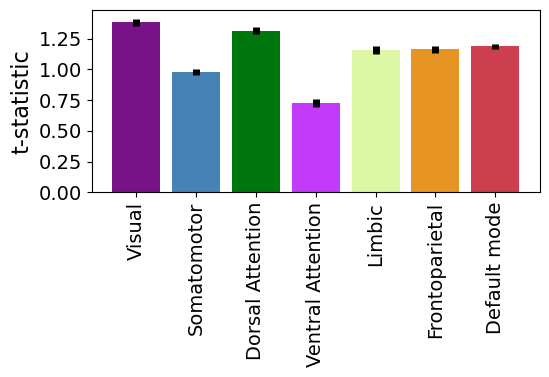

In [372]:
import matplotlib.pyplot as plt
from scipy.stats import sem


from brainstat.datasets import fetch_yeo_networks_metadata

yeo_networks = fetch_parcellation("fsaverage5", "yeo", 7)
network_names, yeo_colormap = fetch_yeo_networks_metadata(7)

from brainstat.context.resting import yeo_networks_associations

yeo_tstat_mean = yeo_networks_associations(slm_grouppas.t.flatten(), "fsaverage5")
yeo_tstat_sem = yeo_networks_associations(
    slm_grouppas.t.flatten(),
    "fsaverage5",
    reduction_operation=lambda x, y: sem(x, nan_policy="omit"),
)

plt.bar(
    np.arange(7),
    yeo_tstat_mean[:, 0],
    yerr=yeo_tstat_sem.flatten(),
    color=yeo_colormap,
    error_kw={"elinewidth": 5},
)
plt.xticks(np.arange(7), network_names, rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("t-statistic", fontdict={"fontsize": 16})
plt.gcf().subplots_adjust(left=0.2, bottom=0.5)
plt.show()

In [231]:
from brainspace.utils.parcellation import reduce_by_labels
t_stat_schaefer_100 = reduce_by_labels(slm_grouppas.t.flatten(), yeo_networks)[1:]
t_stat_schaefer_100

array([       nan, 0.63121264, 0.7319455 ,        nan,        nan,
       0.61939632,        nan])

In [179]:
#pip install wordcloud
import matplotlib.pyplot as plt
from brainstat.context.meta_analysis import meta_analytic_decoder
from wordcloud import WordCloud
meta_analysis = meta_analytic_decoder("fsaverage5", slm_grouppas.t.flatten())
wc = WordCloud(background_color="white", random_state=0)
wc.generate_from_frequencies(frequencies=meta_analysis.to_dict()["Pearson's r"])
plt.imshow(wc)
plt.axis("off")
plt.show()

In [ ]:
from brainstat.context.meta_analysis import radar_plot
numFeat = 8
data = meta_analysis.to_numpy()[:numFeat]
label = meta_analysis.index[:numFeat]
radar_plot(data, label=label, axis_range=(0.18, 0.22))

# HC VS PD



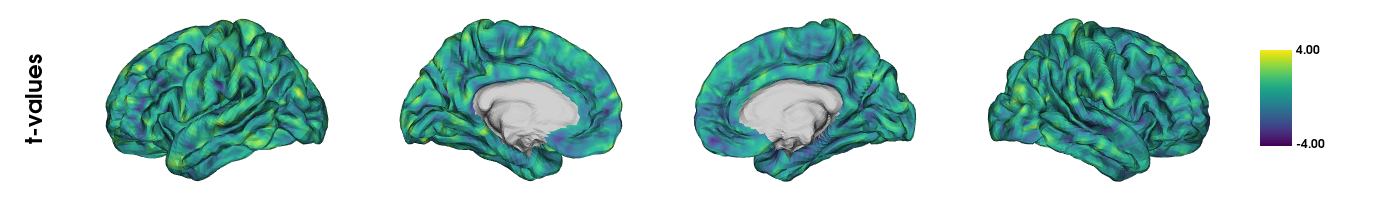

In [305]:
term_group_hc_pd = FixedEffect(val.GROUP_NAME_PDvsHC)
model_group_hc_pd = term_group_hc_pd
contrast_group_hc_pd = (val.GROUP_NAME_PDvsHC == "PD").astype(int) - (val.GROUP_NAME_PDvsHC == "HC").astype(
    int
)

term_age = FixedEffect(val.Age)
model_age = term_age

model_groupage_hc_pd = term_age + term_group_hc_pd

slm_group_hc_pd = SLM(
    model_group_hc_pd,
    contrast_group_hc_pd,
    surf=pial_combined,
    mask=mask,
    correction=["fdr", "rft"],
    two_tailed=False,
    cluster_threshold=0.01,
)
slm_group_hc_pd.fit(thickness)
plot_hemispheres(pial_left, pial_right, slm_group_hc_pd.t, color_bar=True, color_range=(-4, 4),
        label_text=["t-values"], cmap="viridis", embed_nb=True, size=(1400, 200), zoom=1.45,
        nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, interactive=False,transparent_bg=False)

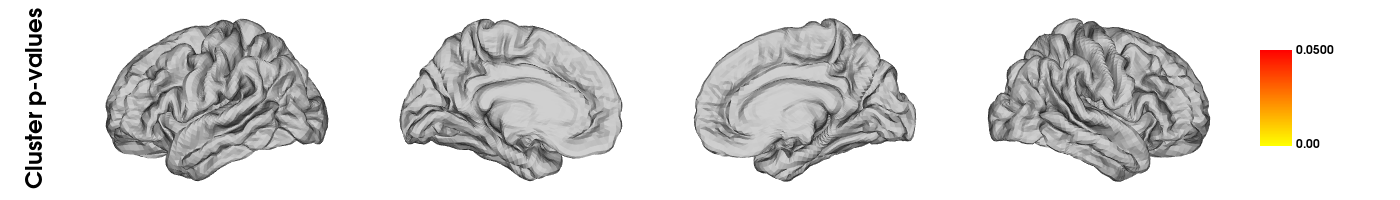

In [306]:
cp = [np.copy(slm_group_hc_pd.P["pval"]["C"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in cp]
plot_hemispheres(pial_left, pial_right, cp[0].T, color_bar=True, color_range=(0, 0.05),
        label_text=["Cluster p-values"], cmap="autumn_r", embed_nb=True, size=(1400, 200), 
        zoom=1.45, nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, 
        interactive=False,transparent_bg=False)

# Anx Vs NoAnx

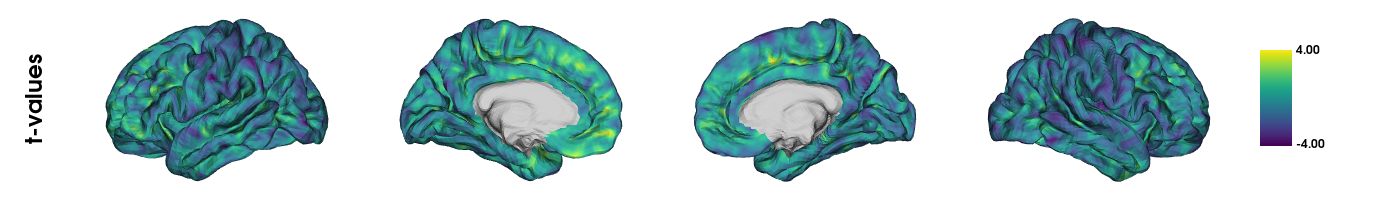

In [310]:
term_group_hc_pd = FixedEffect(val.GROUP_NAME_FUS)
model_group_hc_pd = term_group_hc_pd
contrast_group_hc_pd = (val.GROUP_NAME_FUS == "NoAnx").astype(int) - (val.GROUP_NAME_FUS == "anxPD").astype(
    int
)

slm_group_hc_pd = SLM(
    model_group_hc_pd,
    contrast_group_hc_pd,
    surf=pial_combined,
    mask=mask,
    correction=["fdr", "rft"],
    two_tailed=False,
    cluster_threshold=0.01,
)
slm_group_hc_pd.fit(thickness)
plot_hemispheres(pial_left, pial_right, slm_group_hc_pd.t, color_bar=True, color_range=(-4, 4),
        label_text=["t-values"], cmap="viridis", embed_nb=True, size=(1400, 200), zoom=1.45,
        nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, interactive=False,transparent_bg=False)

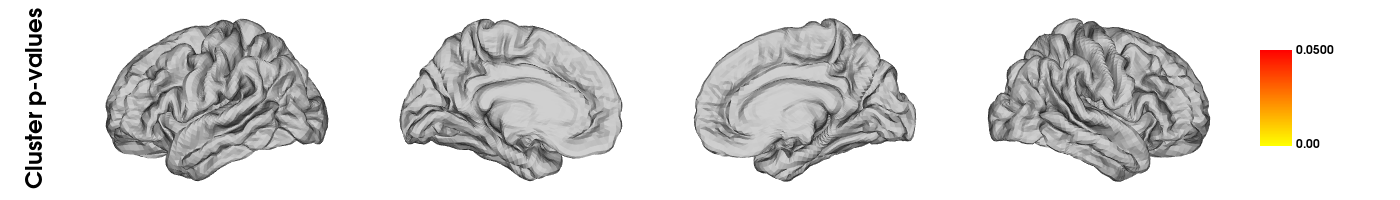

In [311]:
cp = [np.copy(slm_group_hc_pd.P["pval"]["C"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in cp]
plot_hemispheres(pial_left, pial_right, cp[0].T, color_bar=True, color_range=(0, 0.05),
        label_text=["Cluster p-values"], cmap="autumn_r", embed_nb=True, size=(1400, 200), 
        zoom=1.45, nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, 
        interactive=False,transparent_bg=False)

In [105]:
from nilearn import surface
import nilearn
fsaverage = nilearn.datasets.fetch_surf_fsaverage()

img=nib.load('/NAS/tupac/protocoles/PULSE/R2_in_space-MNI152_0.8mm.nii.gz')
texture_r = surface.vol_to_surf(img, fsaverage.pial_right)
texture_l = surface.vol_to_surf(img, fsaverage.pial_left)
texture = np.concatenate([texture_r,texture_l], axis=0)

plot_hemispheres(pial_left, pial_right,texture, color_bar=True, color_range=(10,40),
        cmap="autumn_r", embed_nb=True, size=(1400, 200), 
        zoom=1.45, nan_color=(0.7, 0.7, 0.7, 1), cb__labelTextProperty={"fontSize": 12}, 
        interactive=False,transparent_bg=False)